<a href="https://colab.research.google.com/github/Enterprise-D/sc_multimodal/blob/main/multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Compression

Install and load h5df modules:

In [5]:
!pip install hdf5plugin
import h5py
import hdf5plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


handle inputs:

In [2]:
path_train_multi_inputs = '/content/drive/MyDrive/multimodal/train_multi_inputs.h5'
file_train_multi_inputs = h5py.File(path_train_multi_inputs, "r")

path_test_multi_inputs = '/content/drive/MyDrive/multimodal/test_multi_inputs.h5'
file_test_multi_inputs = h5py.File(path_test_multi_inputs, "r")

file_train_multi_inputs.keys(), file_test_multi_inputs.keys()

(<KeysViewHDF5 ['train_multi_inputs']>, <KeysViewHDF5 ['test_multi_inputs']>)

In [3]:
group_train_multi_inputs = file_train_multi_inputs['train_multi_inputs']

group_test_multi_inputs = file_test_multi_inputs['test_multi_inputs']

group_train_multi_inputs.keys(), group_test_multi_inputs.keys()

(<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>,
 <KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>)

In [4]:
group_train_multi_inputs['block0_values'].shape, \
group_test_multi_inputs['block0_values'].shape
# axis0 & block0_items: features (genomic coordinates, GRCh38)
# axis1: cell_ids
# block0_values: entries

((105942, 228942), (55935, 228942))

In [ ]:
group_train_multi_inputs['block0_values'][1:10,1:6]

handle targets:

In [ ]:
path_train_multi_targets = '/content/drive/MyDrive/multimodal/train_multi_targets.h5'
file_train_multi_targets = h5py.File(path_train_multi_targets, "r")

file_train_multi_targets.keys()

In [ ]:
group_train_multi_targets = file_train_multi_targets['train_multi_targets']
group_train_multi_targets.keys()

In [ ]:
group_train_multi_targets['block0_values'].shape
# axis0 & block0_items: features (expression reads, GRCh38)
# axis1: cell_ids
# block0_values: entries

In [ ]:
group_train_multi_targets['block0_values'][1:10,1:6]

In [ ]:
import numpy as np
import pandas as pd
import os
import scipy.sparse as sps
from tqdm import tqdm as tqdm
import gc

Datasets are too sparse:

In [ ]:
%load_ext Cython

In [ ]:
%%cython

import cython
cimport cython
cimport numpy as np
import numpy as np
from tqdm import tqdm, trange

ctypedef np.int64_t INT64_t

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef np.ndarray[INT64_t, ndim=1] create_indptr(INT64_t[:] row_indices, int start_pos, int nrows):
    cdef int shape = row_indices.shape[0]
    res = np.zeros(nrows, dtype=np.int64)
    cdef INT64_t[:] res_view = res
    
    cdef int i
    cdef int curr_row = 0
    cdef int prev = row_indices[0]
    
    for i in range(shape):
        if row_indices[i] != prev:
            curr_row += 1
            res_view[curr_row] = i
            prev = row_indices[i]
    # res_view[curr_row + 1] = shape
    return res + start_pos

In [ ]:
def create_csr_arrays(h5_file_path):
    def check_size(xs, ys, datas):
        return (xs.nbytes + ys.nbytes + datas.nbytes) * 1e-9

    print(f"\n\nProcessing File {h5_file_path}")
    pbar = tqdm()

    # Initialize Variables
    chunksize = 1000 # Keep it low
    loaded_rows = chunksize
    start = 0
    start_pos = 0
    file_pointer = 0

    # Initialize CSR arrays
    indptr = np.array([], dtype=np.int64)
    indices = np.array([], dtype=np.int32)
    data_s = np.array([], dtype=np.float32)
    
    prefix_filename = h5_file_path.split('/')[-1].replace('.h5', '')

    while chunksize == loaded_rows:

        # Check current size: if the total sum of sizes are > 7GB, then save three arrays and re-initialize them
        size_gb = check_size(indptr, indices, data_s)
        if size_gb > 7.0:
            pbar.set_description(f"Total size is {size_gb}. Saving ..")
            np.save(f"{prefix_filename}_indptr_{file_pointer}.npy", indptr)
            np.save(f"{prefix_filename}_indices_{file_pointer}.npy", indices)
            np.save(f"{prefix_filename}_data_{file_pointer}.npy", data_s)
            # Re-initialize
            indptr = np.array([], dtype=np.int64)
            indices = np.array([], dtype=np.int32)
            data_s = np.array([], dtype=np.float32)
            # Increment pointer
            file_pointer += 1

        pbar.set_description("Reading .h5 chunk")
        df = pd.read_hdf(h5_file_path, start=start, stop=start+chunksize)
        pbar.set_description("Extracting non-zero values")
        x_coords, y_coords = df.values.nonzero()
        tmp_data = df.values[df.values != 0.0]

        loaded_rows = df.shape[0]

        # Convert types
        y_coords = y_coords.astype(np.int32, copy=False)
        tmp_data = tmp_data.astype(np.float32, copy=False)

        # Compress x_coords
        pbar.set_description("Compressing rows values")
        x_coords = create_indptr(x_coords, start_pos=start_pos, nrows=loaded_rows)

        gc.collect()

        # Update variables
        pbar.set_description("Update variables")
        start_pos += y_coords.shape[0]
        start += chunksize
        # Append data at the end of each array
        indptr = np.hstack((indptr, x_coords))
        indices = np.hstack((indices, y_coords))
        data_s = np.hstack((data_s, tmp_data))

        pbar.update(loaded_rows)

    print('Done. Save last files')
    np.save(f"{prefix_filename}_indptr_{file_pointer}.npy", indptr)
    np.save(f"{prefix_filename}_indices_{file_pointer}.npy", indices)
    np.save(f"{prefix_filename}_data_{file_pointer}.npy", data_s)
    
    del indptr, indices, data_s

In [ ]:
create_csr_arrays(path_train_multi_inputs)

In [ ]:
indptr = np.load('train_multi_inputs_indptr_0.npy')
indices = np.load('train_multi_inputs_indices_0.npy')
data = np.load('train_multi_inputs_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_train_multi_inputs['block0_values'].shape[0]
N_COLS = group_train_multi_inputs['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('train_multi_inputs_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
create_csr_arrays(path_train_multi_targets)

In [ ]:
indptr = np.load('train_multi_targets_indptr_0.npy')
indices = np.load('train_multi_targets_indices_0.npy')
data = np.load('train_multi_targets_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_train_multi_targets['block0_values'].shape[0]
N_COLS = group_train_multi_targets['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('train_multi_targets_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
create_csr_arrays(path_test_multi_inputs)

In [ ]:
indptr = np.load('test_multi_inputs_indptr_0.npy')
indices = np.load('test_multi_inputs_indices_0.npy')
data = np.load('test_multi_inputs_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_test_multi_inputs['block0_values'].shape[0]
N_COLS = group_test_multi_inputs['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('test_multi_inputs_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
!mv *.npy /content/drive/MyDrive/multimodal_sparse
!mv *.npz /content/drive/MyDrive/multimodal_sparse

## Denoising and Normalization

In [ ]:
import numpy as np
import pandas as pd
from sklearn import decomposition

import os
import scipy.sparse as sps
from tqdm import tqdm as tqdm
import gc

Copy data to local disk and load into python:

In [ ]:
!cp /content/drive/MyDrive/multimodal_sparse/*.npz /content/

In [ ]:
train_input = sps.load_npz('/content/train_multi_inputs_sparse.npz')
train_target = sps.load_npz('/content/train_multi_targets_sparse.npz')

Dimensionality reduction with Meta Randomized SVD: 

In [ ]:
!pip install fbpca
import fbpca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11377 sha256=f6b3f7323e0dcd5c33ebeb8d88be6ad9b5ca1512527d82c578e9f211aea5fa12
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
Successfully built fbpca


In [ ]:
k_svd_input = 128
U_input, s_input, Va_input = fbpca.pca(train_input,k=k_svd_input)


np.save("U_input.npy", U_input)
np.save("s_input.npy", s_input)
np.save("Va_input.npy", Va_input)

In [ ]:
k_svd_target = 128
U_target, s_target, Va_target = fbpca.pca(train_target,k=k_svd_target)

np.save("U_target.npy", U_target)
np.save("s_target.npy", s_target)
np.save("Va_target.npy", Va_target)

In [ ]:
!mv *.npy /content/drive/MyDrive/multimodal_compiled

## PyTorch Workflow

In [14]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

In [2]:
!cp /content/drive/MyDrive/multimodal_compiled/*.npy /content/

In [4]:
U_input = np.load("U_input.npy")
U_target = np.load("U_target.npy")

Normalize targets (for MSE calculation):

In [39]:
U_input_std = U_input.std(axis=1).reshape(-1, 1)
U_input_avg = U_input.mean(axis=1).reshape(-1, 1)
U_input_norm = (U_input - U_input_avg) / U_input_std

U_target_std = U_target.std(axis=1).reshape(-1, 1)
U_target_avg = U_target.mean(axis=1).reshape(-1, 1)
U_target_norm = (U_target - U_target_avg) / U_target_std

U_target_norm.shape, U_target_avg.shape, U_target_std.shape

((105942, 128), (105942, 1), (105942, 1))

Construct dataset:

In [40]:
class TrainDataset(Data.Dataset):
    def __init__(self):
      self.inputs_data = U_input_norm.astype('float32')
      self.targets_data = U_target_norm.astype('float32')
      self.targets_std = U_target_std.astype('float32')
      self.targets_avg = U_target_avg.astype('float32')

    def __len__(self):
      return self.inputs_data.shape[0]

    def __getitem__(self, idx):
      inputs_sliced = self.inputs_data[idx, ...]
      targets_sliced = self.targets_data[idx, ...]
      targets_std_sliced = self.targets_std[idx, ...]
      targets_avg_sliced = self.targets_avg[idx, ...]

      return inputs_sliced, targets_sliced, targets_std_sliced, targets_avg_sliced

In [41]:
validation_split = .2
shuffle_dataset = True
random_seed = 42

# Creating data indices for training and validation splits:
dataset_size = len(TrainDataset())
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [69]:
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(TrainDataset(),
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               shuffle = False)
valid_dataloader = torch.utils.data.DataLoader(TrainDataset(), 
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               shuffle = False)

len(train_dataloader), len(valid_dataloader)

(332, 83)

Construct models:

In [101]:
class DenseModel(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, output_size=128):
        super(DenseModel, self).__init__()
        self.dense1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU())
        
        self.dense2 = nn.Sequential(
            #nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU())
        
        self.dense3 = nn.Sequential(
            #nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU())
        
        self.dense4 = nn.Sequential(
            #nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU())
                
        self.dense5 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, output_size))

    def forward(self, input):
        output = self.dense1(input)
        output = self.dense2(output)
        output = self.dense3(output)
        #output = self.dense4(output)
        output = self.dense5(output)
        return output

In [77]:
dense_model = DenseModel().cuda()

In [78]:
criterion = nn.MSELoss()

num_epochs = 20
learning_rate = 0.01
optimizer = torch.optim.Adam(params=dense_model.parameters(), lr=learning_rate)

total_step = len(train_dataloader)

In [102]:
metric_train = np.zeros(shape=num_epochs)
metric_valid = np.zeros(shape=num_epochs)

for epoch in range(num_epochs):
    dense_model.train()
    loss_train = np.zeros(shape=len(train_dataloader))

    for i, (inputs, targets, _, _) in enumerate(train_dataloader):

        inputs = inputs.cuda()
        targets = targets.cuda()

        outputs = dense_model(inputs)
        loss = criterion(outputs, targets)
        loss_train[i] = loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if (i+1) % 100 == 0:
        #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.10f}'
        #           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    dense_model.eval()
    loss_valid = np.zeros(shape=len(valid_dataloader))

    with torch.no_grad():
        for i, (inputs, targets, _, _) in enumerate(valid_dataloader):

          inputs = inputs.cuda()
          targets = targets.cuda()

          outputs = dense_model(inputs)
          loss = criterion(outputs, targets)
          loss_valid[i] = loss

    metric_train[epoch] = np.mean(loss_train)
    metric_valid[epoch] = np.mean(loss_valid)

    print('Epoch', epoch+1,'| train:',round(metric_train[epoch],4) ,'| valid:',round(metric_valid[epoch],4))

Epoch 1 | train: 0.8698 | valid: 0.8694
Epoch 2 | train: 0.8677 | valid: 0.8673


KeyboardInterrupt: ignored

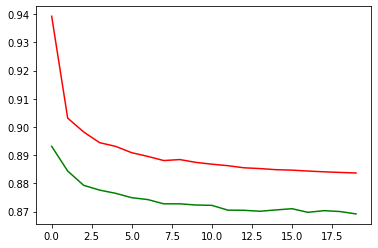

In [30]:
plt.plot(metric_train, color='r')
plt.plot(metric_valid, color='g')
plt.show()

### Evaluation by correlation

Load s and Va from SVD:

In [117]:
s_input = np.diag(np.load("s_input.npy"))
s_target = torch.from_numpy(np.diag(np.load("s_target.npy")).astype('float32')).cuda()

Va_input = np.load("Va_input.npy")
Va_target = torch.from_numpy(np.load("Va_target.npy").astype('float32')).cuda()

Vectorized version of pearson correlation coefficient:

In [118]:
def pcorr_vec(X,Y):
  Xmean = X.mean(axis=1).reshape(-1, 1)
  Ymean = Y.mean(axis=1).reshape(-1, 1)
  Xnorm = X-Xmean
  Ynorm = Y-Ymean
  cov = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Ynorm,1,0)))
  Xsigma = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Xnorm,1,0)))
  Ysigma = torch.diagonal(torch.matmul(Ynorm,torch.transpose(Ynorm,1,0)))
  sigma = torch.sqrt(torch.mul(Xsigma,Ysigma))
  return torch.mean(cov/sigma)

In [119]:
dense_model.eval()

pcorr_avg = np.zeros(shape=len(valid_dataloader))

with torch.no_grad():
    for i, (inputs, targets, targets_std, targets_avg) in enumerate(valid_dataloader):

      inputs = inputs.cuda()
      targets = targets.cuda()
      targets_std = targets_std.cuda()
      targets_avg = targets_avg.cuda()

      outputs = dense_model(inputs)

      targets = targets * targets_std + targets_avg
      outputs = outputs * targets_std + targets_avg

      A_targets = torch.matmul(torch.matmul(targets,s_target),Va_target)
      A_outputs = torch.matmul(torch.matmul(outputs,s_target),Va_target)

      pcorr_avg[i] = pcorr_vec(A_targets,A_outputs)

np.mean(pcorr_avg)

0.747620303228677